# ML Challenge Problem 6 Part 4

NOTE: This notebook was not actually used to train the final model since that would take forever here. Instead, it was exported to an executable script which was run on a sciml190X node where GPUs were available. Final development of that model was done in the script which is available here. The important parts of the script were then copied back her and cleaned up to make it all easier to read. 

<hr>

This notebook was used to define and train the model used to predict
ped,A1,t1 values for just the single pulse waveforms. A single model
was made, but with 3 branches corresponding to each of the 3 parameters.
The only layer the branches had in common was the input layer. This 
allowed the model for each branch to be developed independently from
the others. 

In [1]:
# Read the full data file into a dataframe
# This file does not have a header so we define the column names here explicitly

import pandas as pd
import numpy as np

TRAIN_FILE  = '/home/davidl/work2/2020.08.12.ML_challenge6/Aug_2020_ML_train.csv'

# Columns in input file. First 5 are labels
names = ['ped', 'A1', 'A2', 't1', 't2']

# Next 128 are features (waveform)
for i in range(0,128): names.append('s%03d' % i)

# Read file and print how many waveforms are found
df = pd.read_csv(TRAIN_FILE, names=names)
print('Number of waveforms: %d' % len(df.index))

Number of waveforms: 190071


Define slices of dataframe for the 0,1, and 2 pulse waveforms.

In [2]:
# Make slices containing only 0,1,2 identified pulses
dfno_pulses = df[(df.A1==0) & (df.A2==0)]
dfA1_not_A2 = df[(df.A1!=0) & (df.A2==0)]
dfA2_not_A1 = df[(df.A1==0) & (df.A2!=0)]

## Define Model

In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Lambda, Conv1D, Concatenate, AveragePooling1D
from tensorflow.keras.optimizers import SGD, Adamax, Adadelta, Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
import tensorflow.keras.backend as K
import tensorflow.keras.losses
import tensorflow as tf

NINPUTS = 128

#-----------------------------------------------------
# DefineModel
#-----------------------------------------------------
def DefineModel():

    # Here we build the network model.
    # This model is made of multiple parts. The first handles the
    # inputs and identifies common features. The rest are branches with
    # each determining an output parameter from those features.
    inputs       = Input(shape=(NINPUTS,1), name='waveform')
    pedmodel     = DefinePedModel(inputs)
    timmodel     = DefineTimeModel(inputs)
    ampmodel     = DefineAmplitudeModel(inputs, pedmodel, timmodel)
    model        = Model(inputs=inputs, outputs=[pedmodel,ampmodel,timmodel])

    loss_weights = {'ped_output':1.0/5.0, 'amp_output':1.0/200.0, 'time_output':1.0/40.0}

    # Compile the model
    opt = Adadelta(learning_rate=0.01, rho=0.98)
    model.compile(loss='mse', loss_weights=loss_weights, optimizer=opt, metrics=['mae', 'mse'])

    return model

#-----------------------------------------------------
# DefinePedModel
#-----------------------------------------------------
def DefinePedModel(inputs):

    x = Conv1D(128, (32), name='ped_conv1', activation='tanh', kernel_initializer="glorot_normal")(inputs)
    x = Conv1D(32, (8), name='ped_conv2', activation='tanh', kernel_initializer="glorot_normal")(x)
    x = Flatten(name='ped_flatten1')(x)

    # Add value where we calculate the pedestal directly from waveform by averaging
    # samples that lie within band around zero
    x2 = Lambda(CalcPed, arguments={'vmin':-15,'vmax':100})(inputs)
    x = Concatenate(axis=1)([x, x2])

    x = Dense(64, name='ped_layer2', activation='linear', kernel_initializer="glorot_normal")(x)
    x = Dense(32, name='ped_layer3', activation='tanh', kernel_initializer="glorot_normal")(x)
    x = Dense(16, name='ped_layer4', activation='linear', kernel_initializer="glorot_normal")(x)
    x = Dense(1, name='ped_output', activation='linear', kernel_initializer="glorot_normal")(x)
    return x

#-----------------------------------------------------
# DefineAmplitudeModel
#-----------------------------------------------------
def DefineAmplitudeModel(inputs, pedmodel, timmodel):

    x = Conv1D(128, (16), name='amp_conv1', activation='relu', kernel_initializer="glorot_normal")(inputs)
    x = Flatten(name='amp_flatten')(x)
    x = Dense(16, name='amp_layer2', activation='linear', kernel_initializer="glorot_normal")(x)
    x = Dense(1, name='amp_output', activation='relu', kernel_initializer="glorot_normal")(x)
    return x

#-----------------------------------------------------
# DefineTimeModel
#-----------------------------------------------------
def DefineTimeModel(inputs):

    x = Conv1D(128, (32), name='time_conv1', activation='tanh', kernel_initializer="ones")(inputs)
    x = Conv1D(16, (16), name='time_conv2', activation='tanh', kernel_initializer="ones")(x)
    x = Flatten(name='time_flatten')(x)

    # Add in locations and values of max and min. This also adds
    # back in the original 128 inputs from the waveform.
    # This helps quite a bit, but probably only because I'm
    # using 1 pulse waveforms.
    x2 = Lambda(AddMax, output_shape=(132,1), name='time_max')(inputs)
    x2 = Reshape((132,))(x2)
    x = Concatenate(axis=1)([x, x2])

    x = Dense(64, name='time_layer2', activation='linear', kernel_initializer="glorot_normal")(x)
    x = Dense(32, name='time_layer3', activation='tanh',   kernel_initializer="glorot_normal")(x)
    x = Dense(64, name='time_layer4', activation='linear', kernel_initializer="glorot_normal")(x)
    x = Dense(16, name='time_layer5', activation='tanh', kernel_initializer="glorot_normal")(x)
    x = Dense(1, name='time_output', activation='linear', kernel_initializer="glorot_normal")(x)
    return x

#-----------------------------------------------------
# AddMax
#-----------------------------------------------------
def AddMax(inputs):
    xmax = K.max(inputs, axis=1, keepdims=True)
    xmin = K.min(inputs, axis=1, keepdims=True)
    xlocmax = K.expand_dims(K.cast_to_floatx(K.argmax(inputs, axis=1)))
    xlocmin = K.expand_dims(K.cast_to_floatx(K.argmin(inputs, axis=1)))
    output = K.concatenate([inputs, xmax, xmin, xlocmax, xlocmin], axis=1)
    return output

#-----------------------------------------------------
# CalcPed
#-----------------------------------------------------
def CalcPed(inputs, vmin=-15.0, vmax=100.0):

    # Calculate mask of values in the inputs that fall between the minimum and maximum
    min_mask = vmin*K.ones_like(inputs)
    min_mask = K.cast_to_floatx(K.greater(inputs, min_mask))
    max_mask = vmax*K.ones_like(inputs)
    max_mask = K.cast_to_floatx(K.less(inputs, max_mask))

    # Combine upper and lower limit masks into single mask of values to average and apply
    mask = min_mask*max_mask
    sparse_waveforms = inputs * mask

    # Find average of elements not filtered by mask
    Nvals = K.sum(mask, axis=1)
    Sum = K.sum(sparse_waveforms, axis=1)

    avg = tf.math.divide_no_nan(Sum, Nvals)
    ped = avg
    #ped = -K.expand_dims(avg)  # n.b. minus sign is because initial wave form has sign inverted

    return ped

#=====================================================
model = DefineModel()
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
waveform (InputLayer)           [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
time_conv1 (Conv1D)             (None, 97, 128)      4224        waveform[0][0]                   
__________________________________________________________________________________________________
ped_conv1 (Conv1D)              (None, 97, 128)      4224        waveform[0][0]                   
__________________________________________________________________________________________________
time_conv2 (Conv1D)             (None, 82, 16)       32784       time_conv1[0][0]                 
_______________________________________________________________________________________

## Fit the model

In [102]:
import sys
import time 

EPOCHS = 2000  # (in addition to anything already done)
BS     = 32

# n.b. The early stopping was actually not used in the end and the model was
# just trained for 2000 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    'val_mae', 
    min_delta=0.01, 
    patience=10, 
    restore_best_weights=True, 
    verbose=1
)

# Inputs features and labels are all contained in the same row of the input file.
# Create new dataframes here that slice off the appropriate columns for labels
# and features.
mydf = dfA1_not_A2

# WARNING: This needs to be a list of dataframes with one column each. Giving
# a single dataframe with 3 columns will NOT train properly even though Keras
# will not complain!
# i.e. do NOT do this:  y_labels = mydf.loc[:,['ped','A1','t1']]
y_labels      = [
	mydf.loc[:,['ped']],
	mydf.loc[:,['A1']],
	mydf.loc[:,['t1']]
	]
x_waveform    = mydf.iloc[:,5:133]  # Peel off 128 waveform samples and make them positive
print('  y_labels shape: [' + str(y_labels[0].shape) + ' , ' + str(y_labels[1].shape) + ' , ' + str(y_labels[2].shape) + ']')
print('x_waveform shape: ' + str(x_waveform.shape))
print('  y_labels  type: ' + str(type(y_labels)))
print('x_waveform  type: ' + str(type(x_waveform)))

# Fit the model
FIT_MODEL = False  # Don't fit model in Jupyter notebook
try:
    if FIT_MODEL:
        history = model.fit(
            x = x_waveform,
            y = y_labels,
            batch_size = BS,
            epochs=EPOCHS,
            callbacks=[early_stopping]
            #validation_split=0.2
        )
except KeyboardInterrupt:
    pass

# If run on GPU, then save the trained model. If running in Jupyter notebook,
# then load the model.
if FIT_MODEL:
    models_dir = '/home/davidl/work2/2020.08.12.ML_challenge6/2020.10.27.part4/model_checkpoints_part4'
    model_save_dir = models_dir + '/' + time.strftime('%Y.%m.%d-%H:%M')
    print('model_save_dir="%s"' % model_save_dir)
    model.save(model_save_dir)
else:
    model_save_dir = 'final_models/one_pulse_001'
    model = load_model(model_save_dir)

## Plot the results

In [104]:
import os
import matplotlib
import matplotlib.pyplot as plt

# Predict for all waveforms
y_pred = model.predict(x_waveform)
ped_pred   = y_pred[0]
A1_pred    = y_pred[1]
t1_pred    = y_pred[2]

ped_labels = y_labels[0].to_numpy()
A1_labels  = y_labels[1].to_numpy()
t1_labels  = y_labels[2].to_numpy()

# Make diff and remove outermost dimension
ped_diff = (ped_pred - ped_labels).squeeze()
A1_diff  = (A1_pred - A1_labels).squeeze()
t1_diff  = (t1_pred - t1_labels).squeeze()

# Put differences into dataframe so we can make histograms
y_diff = np.array([ped_diff, A1_diff, t1_diff]).transpose()
y_diff = pd.DataFrame(y_diff, columns=['ped','A1', 't1'])

#matplotlib.use('Agg')  # prevent trying to open a window
fig, ax = plt.subplots(2,3, figsize=(20,5.0))

# Histograms of difference between model prediction and truth
y_diff.hist(ax=ax[0,0], column=['ped'], bins=np.linspace(-10.0, 10.0, 100), color='green')
y_diff.hist(ax=ax[0,1], column=['A1'], bins=np.linspace(-10.0, 10.0, 100), color='blue')
y_diff.hist(ax=ax[0,2], column=['t1'], bins=np.linspace(-100.0, 100.0, 100), color='red')

# Scatter plot ped
ax[1,0].scatter(ped_pred, ped_labels, color='green')
ax[1,0].set_xlim([-50, 50])
ax[1,0].set_ylim([-50, 50])
ax[1,0].set_xlabel('ped model')
ax[1,0].set_ylabel('ped label')

# Scatter plot A1
ax[1,1].scatter(A1_pred, A1_labels, color='blue')
ax[1,1].set_xlim([-100, 2048])
ax[1,1].set_ylim([-100, 2048])
ax[1,1].set_xlabel('A1 model')
ax[1,1].set_ylabel('A1 label')

# Scatter plot t1
ax[1,2].scatter(t1_pred, t1_labels, color='red')
ax[1,2].set_xlim([0, 80])
ax[1,2].set_ylim([0, 80])
ax[1,2].set_xlabel('t1 model')
ax[1,2].set_ylabel('t1 label')

plt.savefig('conv1D_results.png')

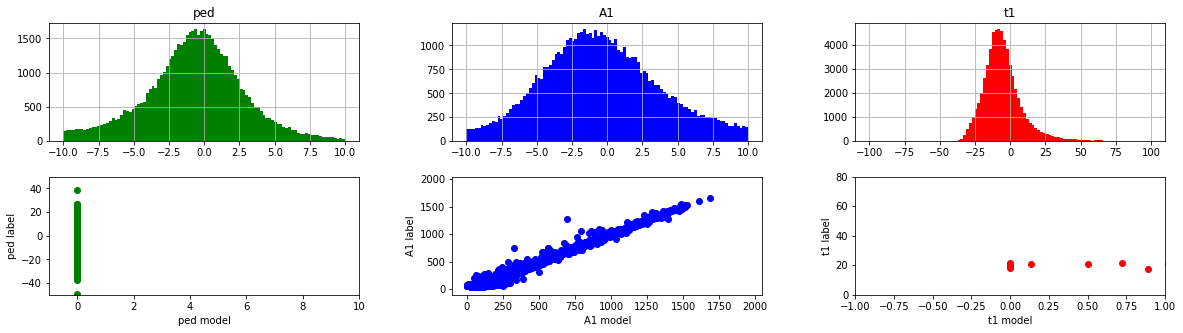

In [104]:
import matplotlib.pyplot as plt

y_pred = model.predict(x_waveform)
y_diff = y_pred - y_labels

fig, ax = plt.subplots(2,3, figsize=(20,5.0))

# Histograms of difference between model prediction and truth
y_diff.hist(ax=ax[0,0], column=['ped'], bins=np.linspace(-10.0, 10.0, 100), color='green')
y_diff.hist(ax=ax[0,1], column=['A1'], bins=np.linspace(-10.0, 10.0, 100), color='blue')
y_diff.hist(ax=ax[0,2], column=['t1'], bins=np.linspace(-100.0, 100.0, 100), color='red')

# Scatter plot ped
x = y_pred[:,0]
y = y_labels.loc[:,'ped'].to_numpy()
ax[1,0].scatter(x, y, color='green')
ax[1,0].set_xlim([-1, 10])
ax[1,0].set_ylim([-50, 50])
ax[1,0].set_xlabel('ped model')
ax[1,0].set_ylabel('ped label')

# Scatter plot A1
x = y_pred[:,1]
y = y_labels.loc[:,'A1'].to_numpy()
ax[1,1].scatter(x, y, color='blue')
ax[1,1].set_xlim([-100, 2048])
ax[1,1].set_ylim([-100, 2048])
ax[1,1].set_xlabel('A1 model')
ax[1,1].set_ylabel('A1 label')

# Scatter plot t1
x = y_pred[:,2]
y = y_labels.loc[:,'t1'].to_numpy()
ax[1,2].scatter(x, y, color='red')
ax[1,2].set_xlim([-1, 1])
ax[1,2].set_ylim([0, 80])
ax[1,2].set_xlabel('t1 model')
ax[1,2].set_ylabel('t1 label')

plt.savefig('conv1D_results.png')